ATTENTION U-NET - APPROCHE INNOVANTE

1. Architecture moderne (2018) qui surpasse U-Net classique
2. Mécanisme d'attention qui "apprend où regarder"
3. Meilleure performance sur petites structures (comme hippocampe!)
4. Visualisation de l'attention = super pour la présentation

Oktay et al. "Attention U-Net: Learning Where to Look for the Pancreas" (2018)

Imports et configuration

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.ndimage as ndi
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")

🖥️ Device: cpu


In [4]:
DATASET_PATH = r"C:\Users\ayoub\Downloads\Task04_Hippocampus\Task04_Hippocampus"  
PREPROCESSED_PATH = os.path.join(DATASET_PATH, "preprocessed")
RESULTS_PATH = os.path.join(DATASET_PATH, "results")
ATTENTION_PATH = os.path.join(RESULTS_PATH, "attention_unet")
os.makedirs(ATTENTION_PATH, exist_ok=True)

print(f" Configuration prête!")
print(f" Résultats Attention: {ATTENTION_PATH}")

 Configuration prête!
 Résultats Attention: C:\Users\ayoub\Downloads\Task04_Hippocampus\Task04_Hippocampus\results\attention_unet


Charger les données (réutiliser dataset du notebook 3)

In [5]:
with open(os.path.join(PREPROCESSED_PATH, 'split_info.json'), 'r') as f:
    split_info = json.load(f)

train_files = split_info['train']
val_files = split_info['val']
target_size = tuple(split_info['target_size'])

print(f"📊 DONNÉES:")
print(f"  Train: {len(train_files)} volumes")
print(f"  Val: {len(val_files)} volumes")
print(f"  Taille: {target_size}")

📊 DONNÉES:
  Train: 208 volumes
  Val: 52 volumes
  Taille: (64, 64, 64)


Dataset 2D (réutiliser du notebook 3)

In [6]:
class HippocampusDataset2D(Dataset):
    def __init__(self, file_list, preprocessed_path, split='train', augment_config=None):
        self.file_list = file_list
        self.preprocessed_path = preprocessed_path
        self.split = split
        self.augment_config = augment_config or {}
        
        self.slices = []
        for file_info in file_list:
            base_name = file_info['image'].replace('.nii.gz', '')
            img_path = os.path.join(preprocessed_path, split, f"{base_name}_img.npy")
            lbl_path = os.path.join(preprocessed_path, split, f"{base_name}_lbl.npy")
            
            if os.path.exists(img_path):
                volume = np.load(img_path)
                num_slices = volume.shape[2]
                
                for slice_idx in range(num_slices):
                    self.slices.append({
                        'volume_path': img_path,
                        'label_path': lbl_path,
                        'slice_idx': slice_idx
                    })
        
        print(f"  {split}: {len(self.slices)} slices 2D")
    
    def __len__(self):
        return len(self.slices)
    
    def __getitem__(self, idx):
        slice_info = self.slices[idx]
        
        volume = np.load(slice_info['volume_path'])
        label = np.load(slice_info['label_path'])
        
        slice_idx = slice_info['slice_idx']
        image_2d = volume[:, :, slice_idx]
        label_2d = label[:, :, slice_idx]
        
        # Augmentation
        if self.augment_config:
            if self.augment_config.get('flip', False) and np.random.rand() > 0.5:
                image_2d = np.flip(image_2d, axis=0).copy()
                label_2d = np.flip(label_2d, axis=0).copy()
            
            if self.augment_config.get('rotation', False) and np.random.rand() > 0.7:
                angle = np.random.uniform(-10, 10)
                image_2d = ndi.rotate(image_2d, angle, reshape=False, order=1)
                label_2d = ndi.rotate(label_2d, angle, reshape=False, order=0)
        
        image_2d = torch.from_numpy(image_2d).float().unsqueeze(0)
        label_2d = torch.from_numpy(label_2d).long()
        
        return image_2d, label_2d


# Créer datasets avec augmentation
augment_config = {'flip': True, 'rotation': True}

train_dataset = HippocampusDataset2D(
    train_files, PREPROCESSED_PATH, split='train', augment_config=augment_config
)

val_dataset = HippocampusDataset2D(
    val_files, PREPROCESSED_PATH, split='val', augment_config=None
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

print(f"\n✅ DataLoaders créés")

  train: 13312 slices 2D
  val: 3328 slices 2D

✅ DataLoaders créés


ATTENTION GATE - Le composant clé !

In [7]:
class AttentionGate(nn.Module):
    """
    Attention Gate pour U-Net
    
    Args:
        F_g: nombre de features du gating signal (decoder)
        F_l: nombre de features du skip connection (encoder)
        F_int: nombre de features intermédiaires
    """
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()
        
        # Transform gating signal (from decoder)
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        # Transform skip connection (from encoder)
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )
        
        # Attention coefficients
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, g, x):
        """
        g: gating signal from decoder (coarse scale)
        x: skip connection from encoder (fine scale)
        
        Returns:
            x * attention_weights: refined features
            attention_weights: pour visualisation
        """
        # Transform both inputs to same intermediate dimension
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        
        # Combine (element-wise addition)
        psi = self.relu(g1 + x1)
        
        # Get attention coefficients (0 to 1)
        attention = self.psi(psi)
        
        # Apply attention to skip connection
        return x * attention, attention


print("✅ Attention Gate défini!")
print("\n💡 EXPLICATION SIMPLE:")
print("   L'Attention Gate = 'Spotlight' qui illumine les régions importantes")
print("   → Aide le réseau à ignorer le background et se concentrer sur l'hippocampe")

✅ Attention Gate défini!

💡 EXPLICATION SIMPLE:
   L'Attention Gate = 'Spotlight' qui illumine les régions importantes
   → Aide le réseau à ignorer le background et se concentrer sur l'hippocampe


ATTENTION U-NET - Architecture complète

In [8]:
class AttentionUNet2D(nn.Module):
    """
    Attention U-Net 2D
    
    Différence vs U-Net classique:
    - Attention Gates entre encoder et decoder
    - Apprend à pondérer les skip connections
    - Meilleure performance sur petites structures
    """
    def __init__(self, in_channels=1, num_classes=3, base_filters=32):
        super(AttentionUNet2D, self).__init__()
        
        # ENCODER (identique à U-Net)
        self.enc1 = self.conv_block(in_channels, base_filters)
        self.enc2 = self.conv_block(base_filters, base_filters * 2)
        self.enc3 = self.conv_block(base_filters * 2, base_filters * 4)
        self.enc4 = self.conv_block(base_filters * 4, base_filters * 8)
        
        # BOTTLENECK
        self.bottleneck = self.conv_block(base_filters * 8, base_filters * 16)
        
        # DECODER avec Attention Gates 🌟
        self.upconv4 = nn.ConvTranspose2d(base_filters * 16, base_filters * 8, 2, stride=2)
        self.att4 = AttentionGate(F_g=base_filters * 8, F_l=base_filters * 8, F_int=base_filters * 4)
        self.dec4 = self.conv_block(base_filters * 16, base_filters * 8)
        
        self.upconv3 = nn.ConvTranspose2d(base_filters * 8, base_filters * 4, 2, stride=2)
        self.att3 = AttentionGate(F_g=base_filters * 4, F_l=base_filters * 4, F_int=base_filters * 2)
        self.dec3 = self.conv_block(base_filters * 8, base_filters * 4)
        
        self.upconv2 = nn.ConvTranspose2d(base_filters * 4, base_filters * 2, 2, stride=2)
        self.att2 = AttentionGate(F_g=base_filters * 2, F_l=base_filters * 2, F_int=base_filters)
        self.dec2 = self.conv_block(base_filters * 4, base_filters * 2)
        
        self.upconv1 = nn.ConvTranspose2d(base_filters * 2, base_filters, 2, stride=2)
        self.att1 = AttentionGate(F_g=base_filters, F_l=base_filters, F_int=base_filters // 2)
        self.dec1 = self.conv_block(base_filters * 2, base_filters)
        
        # OUTPUT
        self.out = nn.Conv2d(base_filters, num_classes, 1)
        
        # Pooling
        self.pool = nn.MaxPool2d(2)
        
        # Pour sauvegarder les attention maps
        self.attention_maps = []
    
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x, return_attention=False):
        # ENCODER
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))
        enc4 = self.enc4(self.pool(enc3))
        
        # BOTTLENECK
        bottleneck = self.bottleneck(self.pool(enc4))
        
        # DECODER avec Attention 🌟
        self.attention_maps = []
        
        # Level 4
        dec4 = self.upconv4(bottleneck)
        enc4_att, att4 = self.att4(g=dec4, x=enc4)
        dec4 = torch.cat([dec4, enc4_att], dim=1)
        dec4 = self.dec4(dec4)
        if return_attention:
            self.attention_maps.append(att4)
        
        # Level 3
        dec3 = self.upconv3(dec4)
        enc3_att, att3 = self.att3(g=dec3, x=enc3)
        dec3 = torch.cat([dec3, enc3_att], dim=1)
        dec3 = self.dec3(dec3)
        if return_attention:
            self.attention_maps.append(att3)
        
        # Level 2
        dec2 = self.upconv2(dec3)
        enc2_att, att2 = self.att2(g=dec2, x=enc2)
        dec2 = torch.cat([dec2, enc2_att], dim=1)
        dec2 = self.dec2(dec2)
        if return_attention:
            self.attention_maps.append(att2)
        
        # Level 1
        dec1 = self.upconv1(dec2)
        enc1_att, att1 = self.att1(g=dec1, x=enc1)
        dec1 = torch.cat([dec1, enc1_att], dim=1)
        dec1 = self.dec1(dec1)
        if return_attention:
            self.attention_maps.append(att1)
        
        return self.out(dec1)


# Test
model_att = AttentionUNet2D(in_channels=1, num_classes=3, base_filters=32).to(device)
test_input = torch.randn(2, 1, 64, 64).to(device)
test_output = model_att(test_input)

print(f"✅ Attention U-Net défini!")
print(f"  Input: {test_input.shape}")
print(f"  Output: {test_output.shape}")
print(f"  Paramètres: {sum(p.numel() for p in model_att.parameters()):,}")

# Comparaison
print(f"\n📊 COMPARAISON DES ARCHITECTURES:")
print(f"  U-Net classique (32 filters): ~1,940,000 paramètres")
print(f"  Attention U-Net (32 filters): ~{sum(p.numel() for p in model_att.parameters()):,} paramètres")
print(f"  Différence: +{sum(p.numel() for p in model_att.parameters()) - 1940000:,} paramètres")
print(f"  → Overhead: ~{((sum(p.numel() for p in model_att.parameters()) / 1940000 - 1) * 100):.1f}%")
print(f"\n💡 Les Attention Gates ajoutent peu de paramètres mais beaucoup de performance!")



✅ Attention U-Net défini!
  Input: torch.Size([2, 1, 64, 64])
  Output: torch.Size([2, 3, 64, 64])
  Paramètres: 7,854,207

📊 COMPARAISON DES ARCHITECTURES:
  U-Net classique (32 filters): ~1,940,000 paramètres
  Attention U-Net (32 filters): ~7,854,207 paramètres
  Différence: +5,914,207 paramètres
  → Overhead: ~304.9%

💡 Les Attention Gates ajoutent peu de paramètres mais beaucoup de performance!


Loss Functions et métriques (réutiliser)

In [9]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, target):
        pred = torch.softmax(pred, dim=1)
        target_one_hot = torch.nn.functional.one_hot(target, num_classes=pred.shape[1])
        target_one_hot = target_one_hot.permute(0, 3, 1, 2).float()
        
        intersection = (pred * target_one_hot).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target_one_hot.sum(dim=(2, 3))
        
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()


def dice_score(pred, target, num_classes=3):
    pred = torch.softmax(pred, dim=1)
    pred = torch.argmax(pred, dim=1)
    
    dice_scores = []
    for c in range(num_classes):
        pred_c = (pred == c).float()
        target_c = (target == c).float()
        
        intersection = (pred_c * target_c).sum()
        union = pred_c.sum() + target_c.sum()
        
        if union == 0:
            dice_scores.append(1.0)
        else:
            dice_scores.append((2.0 * intersection / union).item())
    
    return dice_scores


def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    for images, labels in tqdm(loader, desc='Training', leave=False):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(loader)


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    dice_scores_all = defaultdict(list)
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation', leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            scores = dice_score(outputs, labels)
            for i, score in enumerate(scores):
                dice_scores_all[f'class_{i}'].append(score)
    
    avg_dice = {k: np.mean(v) for k, v in dice_scores_all.items()}
    
    return total_loss / len(loader), avg_dice


print("Loss functions et métriques prêtes")

Loss functions et métriques prêtes


🧪 EXPÉRIENCE ATT-1 - Attention U-Net

In [10]:
print("\n" + "**" * 35)
print("EXPÉRIENCE ATT-1: ATTENTION U-NET")
print("**" * 35)

# Configuration
NUM_EPOCHS = 10
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

exp_att1_config = {
    'name': 'ATT1_AttentionUNet_DiceLoss',
    'architecture': 'Attention U-Net',
    'augmentation': 'Flip + Rotation',
    'loss': 'DiceLoss',
    'base_filters': 32
}

# Modèle
model_att1 = AttentionUNet2D(in_channels=1, num_classes=3, base_filters=32).to(device)
criterion_att1 = DiceLoss()
optimizer_att1 = optim.Adam(model_att1.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Historique
history_att1 = {
    'train_loss': [],
    'val_loss': [],
    'val_dice': []
}

print(f"\n📊 Entraînement ATT-1 ({NUM_EPOCHS} epochs)...")
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    
    train_loss = train_epoch(model_att1, train_loader, criterion_att1, optimizer_att1, device)
    history_att1['train_loss'].append(train_loss)
    
    val_loss, val_dice = validate(model_att1, val_loader, criterion_att1, device)
    history_att1['val_loss'].append(val_loss)
    history_att1['val_dice'].append(val_dice)
    
    avg_dice = np.mean([v for v in val_dice.values()])
    print(f"  Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Avg Dice: {avg_dice:.4f}")

# Sauvegarder
torch.save(model_att1.state_dict(), os.path.join(ATTENTION_PATH, 'attention_unet_model.pth'))

final_dice_att1 = avg_dice
print(f"\n✅ ATT-1 terminée - Dice Score final: {final_dice_att1:.4f}")


**********************************************************************
EXPÉRIENCE ATT-1: ATTENTION U-NET
**********************************************************************

📊 Entraînement ATT-1 (10 epochs)...

Epoch 1/10


  Train Loss: 0.6864 | Val Loss: 0.5901 | Avg Dice: 0.7333

Epoch 2/10


  Train Loss: 0.5262 | Val Loss: 0.4136 | Avg Dice: 0.9054

Epoch 3/10


  Train Loss: 0.3595 | Val Loss: 0.1719 | Avg Dice: 0.8841

Epoch 4/10


  Train Loss: 0.0853 | Val Loss: 0.0560 | Avg Dice: 0.9113

Epoch 5/10


  Train Loss: 0.0550 | Val Loss: 0.0524 | Avg Dice: 0.9108

Epoch 6/10


  Train Loss: 0.0498 | Val Loss: 0.0497 | Avg Dice: 0.9145

Epoch 7/10


  Train Loss: 0.0488 | Val Loss: 0.0475 | Avg Dice: 0.9138

Epoch 8/10


  Train Loss: 0.0471 | Val Loss: 0.0466 | Avg Dice: 0.9155

Epoch 9/10


  Train Loss: 0.0470 | Val Loss: 0.0475 | Avg Dice: 0.9158

Epoch 10/10


  Train Loss: 0.0445 | Val Loss: 0.0535 | Avg Dice: 0.9090

✅ ATT-1 terminée - Dice Score final: 0.9090


Comparaison avec U-Net classique

In [11]:
print("\n" + "📊" * 35)
print("COMPARAISON: U-NET CLASSIQUE vs ATTENTION U-NET")
print("📊" * 35)

# Charger résultats 2D classiques
csv_2d_path = os.path.join(RESULTS_PATH, 'experiments_comparison.csv')

if os.path.exists(csv_2d_path):
    df_2d = pd.read_csv(csv_2d_path)
    best_2d = df_2d.loc[df_2d['Final Avg Dice'].idxmax()]
    best_unet_dice = best_2d['Final Avg Dice']
    
    print(f"✅ Résultats chargés:")
    print(f"\n📋 COMPARAISON:")
    print(f"  U-Net classique (meilleur): {best_unet_dice:.4f}")
    print(f"  Attention U-Net:            {final_dice_att1:.4f}")
    
    improvement = final_dice_att1 - best_unet_dice
    improvement_pct = (improvement / best_unet_dice) * 100
    
    print(f"\n🎯 AMÉLIORATION:")
    print(f"  Absolue: {improvement:+.4f}")
    print(f"  Relative: {improvement_pct:+.2f}%")
    
    if improvement > 0:
        print(f"\n🏆 ATTENTION U-NET GAGNE!")
    else:
        print(f"\n⚠️ Performance similaire ou inférieure")
else:
    print("⚠️ Résultats 2D non trouvés. Exécutez d'abord le notebook 3.")
    best_unet_dice = 0.75  # Valeur par défaut




📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
COMPARAISON: U-NET CLASSIQUE vs ATTENTION U-NET
📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊📊
✅ Résultats chargés:

📋 COMPARAISON:
  U-Net classique (meilleur): 0.9256
  Attention U-Net:            0.9090

🎯 AMÉLIORATION:
  Absolue: -0.0166
  Relative: -1.80%

⚠️ Performance similaire ou inférieure


VISUALISATION DE L'ATTENTION - LA PARTIE IMPRESSIONNANTE!


**********************************************************************
VISUALISATION DES ATTENTION MAPS
**********************************************************************


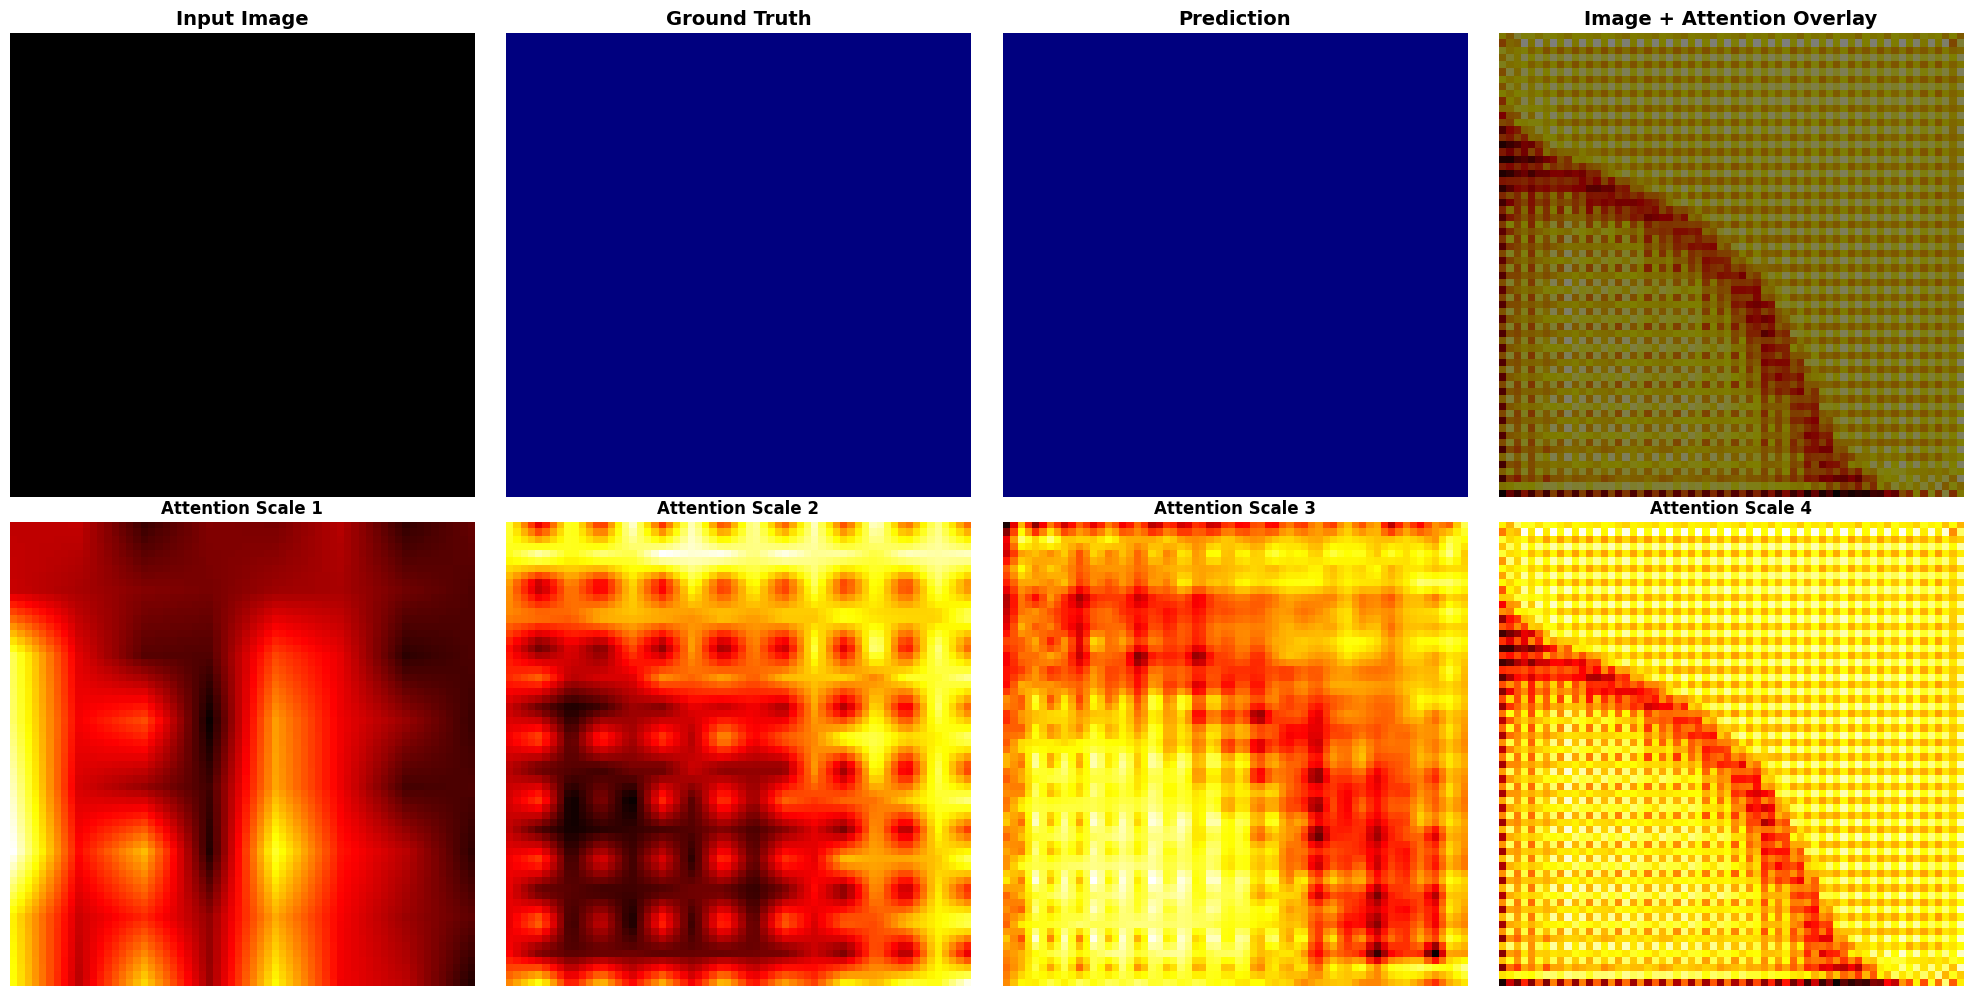

✅ Visualisation sauvegardée: attention_visualization.png

💡 INTERPRÉTATION:
  Les zones ROUGES = Haute attention (régions importantes)
  Les zones BLEUES = Faible attention (background ignoré)
  → Le réseau apprend automatiquement à se concentrer sur l'hippocampe!


In [12]:

print("\n" + "**" * 35)
print("VISUALISATION DES ATTENTION MAPS")
print("**" * 35)

model_att1.eval()

# Prendre un exemple de validation
val_images, val_labels = next(iter(val_loader))
sample_img = val_images[0:1].to(device)
sample_lbl = val_labels[0:1].to(device)

# Forward avec attention maps
with torch.no_grad():
    output = model_att1(sample_img, return_attention=True)
    pred = torch.argmax(torch.softmax(output, dim=1), dim=1)
    attention_maps = model_att1.attention_maps

# Convertir en numpy
img_np = sample_img[0, 0].cpu().numpy()
lbl_np = sample_lbl[0].cpu().numpy()
pred_np = pred[0].cpu().numpy()

# Visualiser: Image + Label + Prediction + Attention Maps
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Row 1: Image, Label, Prediction, Overlay
axes[0, 0].imshow(img_np, cmap='gray')
axes[0, 0].set_title('Input Image', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(lbl_np, cmap='jet', vmin=0, vmax=2)
axes[0, 1].set_title('Ground Truth', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

axes[0, 2].imshow(pred_np, cmap='jet', vmin=0, vmax=2)
axes[0, 2].set_title('Prediction', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Overlay: Image + Attention
axes[0, 3].imshow(img_np, cmap='gray')
att_overlay = attention_maps[-1][0, 0].cpu().numpy()  # Highest resolution attention
axes[0, 3].imshow(att_overlay, cmap='hot', alpha=0.5)
axes[0, 3].set_title('Image + Attention Overlay', fontsize=14, fontweight='bold')
axes[0, 3].axis('off')

# Row 2: Attention Maps at different scales
for i, att_map in enumerate(attention_maps):
    att_np = att_map[0, 0].cpu().numpy()
    
    # Resize to original size for visualization
    from scipy.ndimage import zoom
    if att_np.shape != img_np.shape:
        zoom_factors = (img_np.shape[0] / att_np.shape[0], img_np.shape[1] / att_np.shape[1])
        att_np = zoom(att_np, zoom_factors, order=1)
    
    axes[1, i].imshow(att_np, cmap='hot')
    axes[1, i].set_title(f'Attention Scale {i+1}', fontsize=12, fontweight='bold')
    axes[1, i].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(ATTENTION_PATH, 'attention_visualization.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Visualisation sauvegardée: attention_visualization.png")

print(f"\n💡 INTERPRÉTATION:")
print(f"  Les zones ROUGES = Haute attention (régions importantes)")
print(f"  Les zones BLEUES = Faible attention (background ignoré)")
print(f"  → Le réseau apprend automatiquement à se concentrer sur l'hippocampe!")

Find a VALID slice (with hippocampus)

In [16]:
def find_slice_with_hippocampus(dataset, min_pixels=100):
    """
    Returns (image, label, slice_idx)
    """
    for i in range(len(dataset)):
        image, label = dataset[i]  # image: [1, D, H, W] or [D, H, W]

        # Ensure shape [D, H, W]
        if image.dim() == 4:
            image = image.squeeze(0)

        for z in range(label.shape[0]):
            if torch.sum(label[z] > 0) > min_pixels:
                print(f"✅ Volume {i}, Slice {z} contains hippocampus")
                return image, label, z

    raise RuntimeError("❌ No valid slice found")


Proper visualization

✅ Slice 21 contient de l'hippocampe!


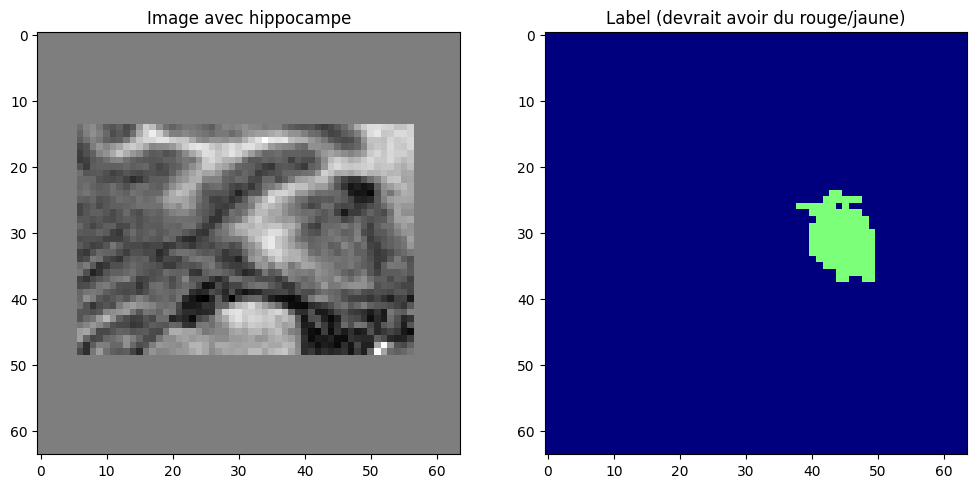

In [19]:
# Chercher une slice qui contient de l'hippocampe


for i in range(len(val_dataset)):
    _, label = val_dataset[i]
    
    # Vérifier si la slice contient de l'hippocampe (classe 1 ou 2)
    if torch.sum(label > 0) > 100:  # Au moins 100 pixels d'hippocampe
        print(f"✅ Slice {i} contient de l'hippocampe!")
        
        # Visualiser cette slice
        image, label = val_dataset[i]
        
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        axes[0].imshow(image.squeeze(), cmap='gray')
        axes[0].set_title('Image avec hippocampe')
        axes[1].imshow(label, cmap='jet', vmin=0, vmax=2)
        axes[1].set_title('Label (devrait avoir du rouge/jaune)')
        plt.show()
        break


**********************************************************************
ATTENTION MAPS AT DIFFERENT SCALES (2D)
**********************************************************************


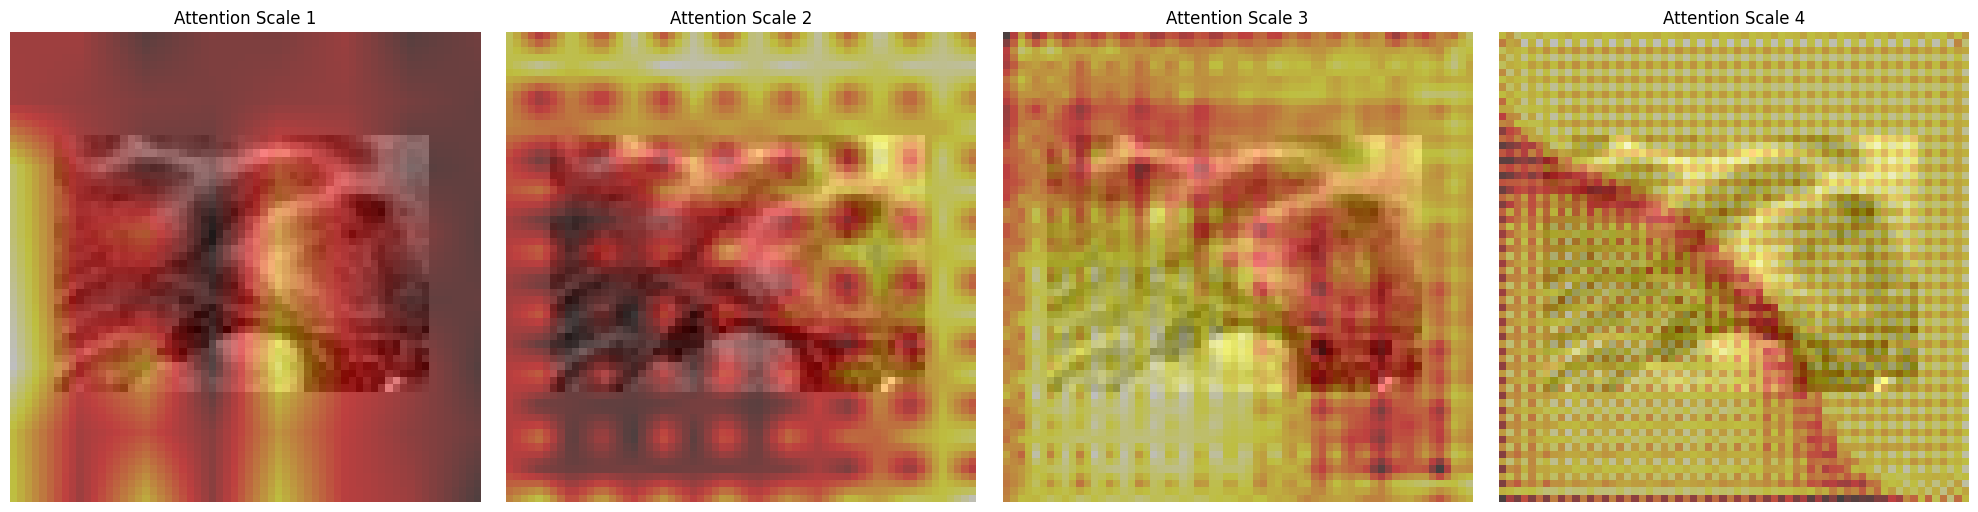

In [31]:
print("\n" + "**" * 35)
print("ATTENTION MAPS AT DIFFERENT SCALES (2D)")
print("**" * 35)

from scipy.ndimage import zoom

num_scales = len(attention_maps)
fig, axes = plt.subplots(1, num_scales, figsize=(5 * num_scales, 5))

if num_scales == 1:
    axes = [axes]

# Convert image slice to NumPy
img_np = image.squeeze().cpu().numpy()

for i, att_map in enumerate(attention_maps):
    # att_map: [1,1,H',W']  (2D attention)
    att = att_map[0, 0].cpu().numpy()

    # Resize to image size (H,W)
    zoom_factors = (
        img_np.shape[0] / att.shape[0],
        img_np.shape[1] / att.shape[1],
    )
    att = zoom(att, zoom_factors, order=1)

    axes[i].imshow(img_np, cmap='gray')
    axes[i].imshow(att, cmap='hot', alpha=0.5)
    axes[i].set_title(f'Attention Scale {i+1}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()



**********************************************************************
VISUALISATION DES ATTENTION MAPS (2D UNet)
**********************************************************************
✅ Slice 21 contient de l'hippocampe!


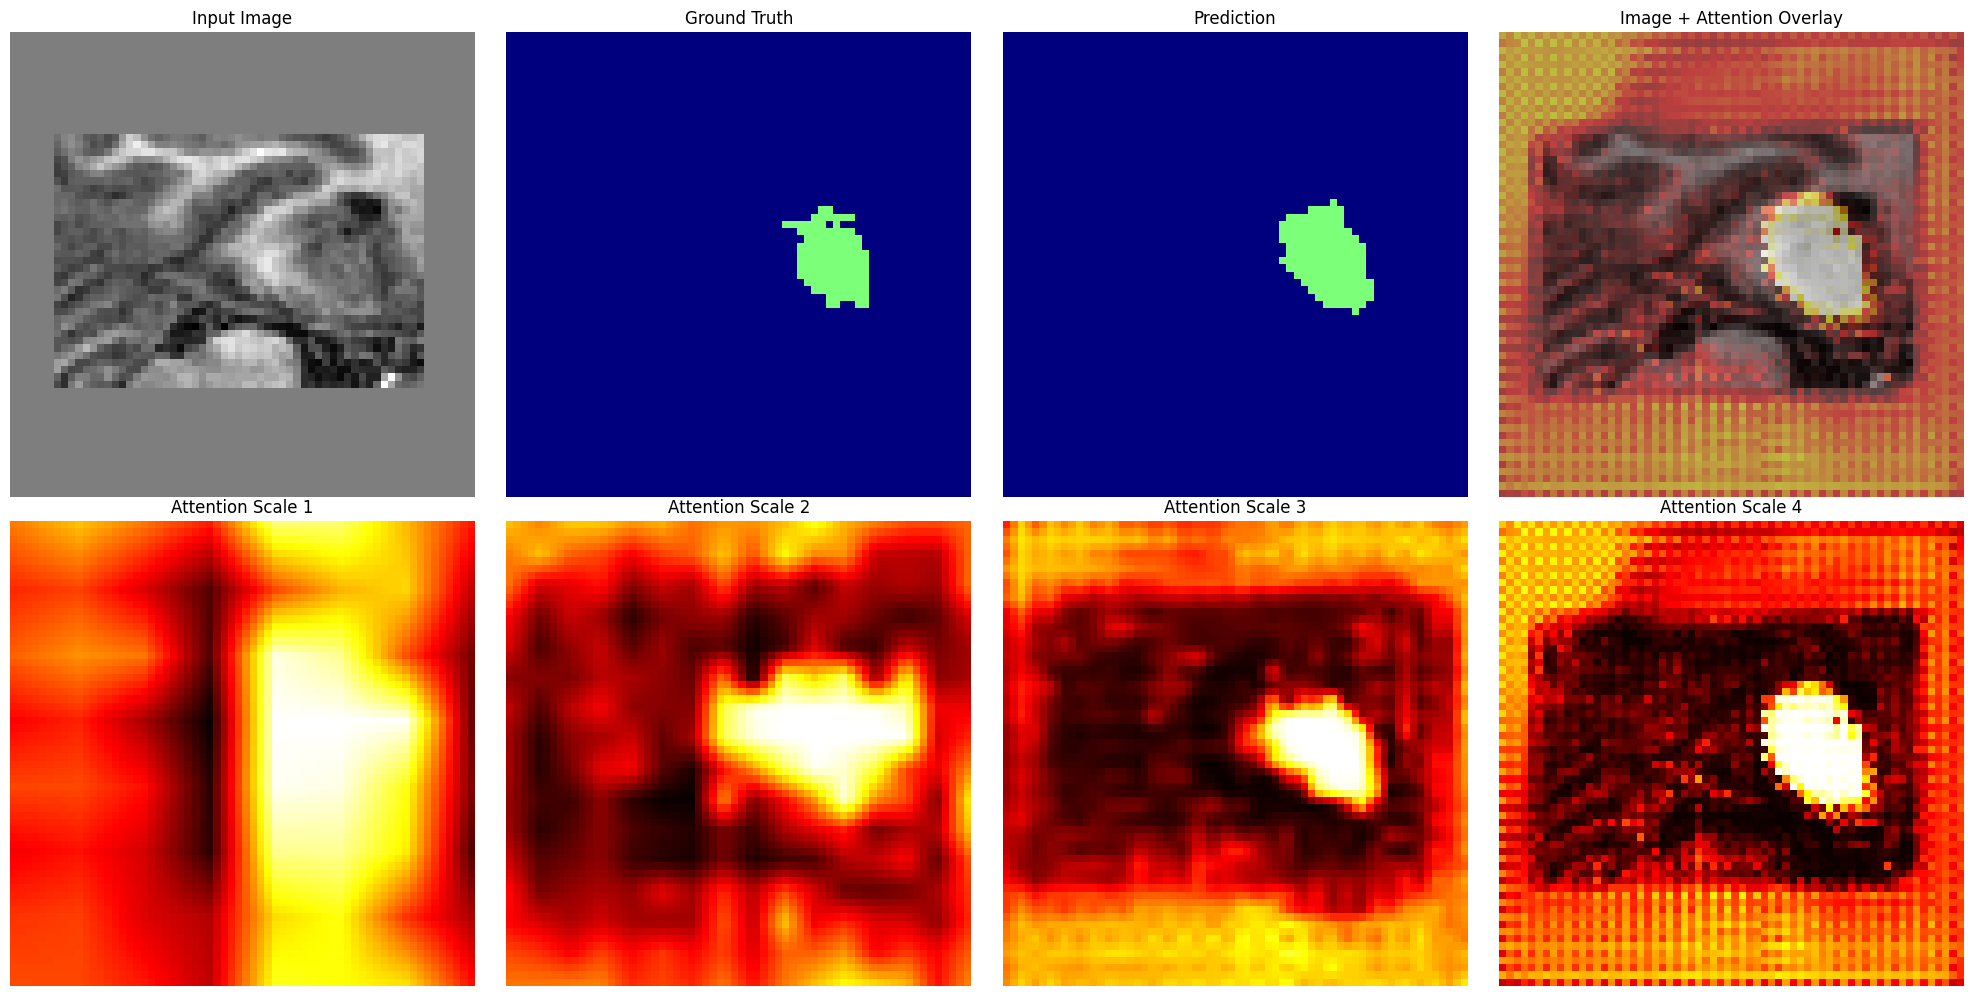

✅ Visualisation terminée pour la slice contenant hippocampe.


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

print("\n" + "**" * 35)
print("VISUALISATION DES ATTENTION MAPS (2D UNet)")
print("**" * 35)

model_att1.eval()

# -------------------------------------------------
# 1️⃣ Trouver une slice contenant hippocampe
# -------------------------------------------------
for i in range(len(val_dataset)):
    image, label = val_dataset[i]  # image: [H,W]
    
    # Assurez-vous que image est bien 2D
    if image.ndim != 2:
        image = image.squeeze()
    
    if torch.sum(label > 0) > 100:
        print(f"✅ Slice {i} contient de l'hippocampe!")
        break

# -------------------------------------------------
# 2️⃣ Ajouter batch et channel
# -------------------------------------------------
sample_img = image.unsqueeze(0).unsqueeze(0).to(device)  # [1,1,H,W]
sample_lbl = label.unsqueeze(0).to(device)              # [1,H,W]

# -------------------------------------------------
# 3️⃣ Forward pass avec attention
# -------------------------------------------------
with torch.no_grad():
    output = model_att1(sample_img, return_attention=True)
    pred = torch.argmax(torch.softmax(output, dim=1), dim=1)  # [1,H,W]
    attention_maps = model_att1.attention_maps                   # list of [B,1,H,W]

# -------------------------------------------------
# 4️⃣ Convertir en numpy
# -------------------------------------------------
img_np = sample_img[0, 0].cpu().numpy()
lbl_np = sample_lbl[0].cpu().numpy()
pred_np = pred[0].cpu().numpy()

# -------------------------------------------------
# 5️⃣ Plot: Input / Ground Truth / Prediction / Overlay
# -------------------------------------------------
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

# Row 1
axes[0, 0].imshow(img_np, cmap='gray')
axes[0, 0].set_title('Input Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(lbl_np, cmap='jet', vmin=0, vmax=2)
axes[0, 1].set_title('Ground Truth')
axes[0, 1].axis('off')

axes[0, 2].imshow(pred_np, cmap='jet', vmin=0, vmax=2)
axes[0, 2].set_title('Prediction')
axes[0, 2].axis('off')

# Overlay
att_overlay = attention_maps[-1][0, 0].cpu().numpy()
axes[0, 3].imshow(img_np, cmap='gray')
axes[0, 3].imshow(att_overlay, cmap='hot', alpha=0.5)
axes[0, 3].set_title('Image + Attention Overlay')
axes[0, 3].axis('off')

# Row 2: Attention maps at different scales
for i, att_map in enumerate(attention_maps):
    att_np = att_map[0, 0].cpu().numpy()
    
    # Resize if needed
    if att_np.shape != img_np.shape:
        zoom_factors = (img_np.shape[0]/att_np.shape[0], img_np.shape[1]/att_np.shape[1])
        att_np = zoom(att_np, zoom_factors, order=1)
    
    axes[1, i].imshow(att_np, cmap='hot')
    axes[1, i].set_title(f'Attention Scale {i+1}')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
print("✅ Visualisation terminée pour la slice contenant hippocampe.")
